# Home Credit Default Risk

1. Introdução
2. Descrição dos dados
3. Carregando os dados
4. Análise Exploratória
5. Correlação | Correlation
6. Feature Selection with Random Forest
7. ...

# 1. Introdução 

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

[Home Credit Group](http://www.homecredit.net/) strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.


# 2. Descrição dos Dados


* application_{train|test}.csv

    * This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    * Static data for all applications. One row represents one loan in our data sample.

* bureau.csv

    * All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
    * For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

* bureau_balance.csv

    * Monthly balances of previous credits in Credit Bureau.
    * This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

* POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.
credit_card_balance.csv

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.
previous_application.csv

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.
installments_payments.csv

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.
HomeCredit_columns_description.csv

This file contains descriptions for the columns in the various data files.

![teste](home_credit.png)

** Pacotes **

In [1]:
# Instalação dos pacotes.
# !pip install imblearn
# !pip install lightgbm

import time
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report

# DataViz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()

# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# plt.style.use('fivethirtyeight')
# plt.style.use('ggplot')
plt.style.use('seaborn')
# sns.set_style('whitegrid')

# Memory management
import gc 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# 3. Carregando os dados

In [8]:
def load_data(data_src):
    
    start_time = time.time()
    
    train = pd.read_csv('{}application_train.csv'.format(data_src))
    test = pd.read_csv('{}application_test.csv'.format(data_src))
    print('Train and test tables loaded.')
    
    bureau = pd.read_csv('{}bureau.csv'.format(data_src))
    bureau_bal = pd.read_csv('{}bureau_balance.csv'.format(data_src))
    print('Bureau data loaded.')
    
    prev = pd.read_csv('{}previous_application.csv'.format(data_src))
    print('Previous applications data loaded.')
    
    cred_card_bal = pd.read_csv('{}credit_card_balance.csv'.format(data_src))
    print('Credit card balance loaded.')
    
    pos_cash_bal = pd.read_csv('{}POS_CASH_balance.csv'.format(data_src))
    print('POS cash balance loaded.')
    
    ins = pd.read_csv('{}installments_payments.csv'.format(data_src))
    print('Installments data loaded.')
    
    # error if using engine c - 'utf-8' codec can't decode byte 0x85
    data_description = pd.read_csv('{}HomeCredit_columns_description.csv'.format(data_src), engine='python')
    
    print('Time it took to load all the data: {:.4f}s\n'.format(time.time() - start_time))
    
    return train, test, bureau, bureau_bal, prev, cred_card_bal, pos_cash_bal, ins, data_description

train, test, bureau, bureau_bal, prev, cred_card_bal, pos_cash_bal, ins, data_description = load_data('data/all/')

# Copia 
df_train = train.copy()
df_test = test.copy()

Train and test tables loaded.
Bureau data loaded.
Previous applications data loaded.
Credit card balance loaded.
POS cash balance loaded.
Installments data loaded.
Time it took to load all the data: 61.0382s



In [19]:
# Copia 
df_train = train.copy()
df_test = test.copy()

print(df_train.shape)
print(df_test.shape)

(307511, 126)
(48744, 125)
(307511, 126)


## Join entre as tabelas dos dados

Juntando os dados e criando novas colunas que podem ser úteis para o modelo. 

In [31]:
def join_tables(train, test, bureau):

    train['CREDIT_INCOME_PERCENT'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
    train['ANNUITY_INCOME_PERCENT'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
    train['CREDIT_TERM'] = train['AMT_ANNUITY'] / train['AMT_CREDIT']
    train['DAYS_EMPLOYED_PERCENT'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']

    test['CREDIT_INCOME_PERCENT'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
    test['ANNUITY_INCOME_PERCENT'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
    test['CREDIT_TERM'] = test['AMT_ANNUITY'] / test['AMT_CREDIT']
    test['DAYS_EMPLOYED_PERCENT'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']

    # Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
    previous_loan_counts = bureau.groupby('SK_ID_CURR', 
                                          as_index=False)['SK_ID_BUREAU']. \
                                            count().rename(columns = 
                                                           {'SK_ID_BUREAU': 
                                                            'previous_loan_counts'})

    previous_loan_counts.head()

    ## Qtde de emprestimos em outras entidades. ESTOU AQUI!!!

    # Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
    previous_loan_counts = bureau.groupby('SK_ID_CURR', 
                                          as_index=False)['SK_ID_BUREAU'].count().rename(columns = 
                                                            {'SK_ID_BUREAU': 
                                                             'previous_loan_counts'}
                                                           )

    train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
    test = test.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
    # Fill the missing values with 0 
    train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
    test['previous_loan_counts'] = test['previous_loan_counts'].fillna(0)


    # Group by the client id, calculate aggregation statistics
    bureau_agg = bureau.drop(['SK_ID_BUREAU'], 
                             axis=1).groupby('SK_ID_CURR', 
                                             as_index = False).agg( \
                                                ['count', 'mean', 
                                                 'max', 'min', 'sum']).reset_index()
    # bureau_agg.head()

    # List of column names
    columns = ['SK_ID_CURR']

    # Iterate through the variables names
    for var in bureau_agg.columns.levels[0]:
        # Skip the id name
        if var != 'SK_ID_CURR':

            # Iterate through the stat names
            for stat in bureau_agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('bureau_%s_%s' % (var, stat))

    # Assign the list of columns names as the dataframe column names
    bureau_agg.columns = columns
    bureau_agg.head()

    # Now we simply merge with the training data as we did before.

    # Merge with the training data
    train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
    test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
    
    return train, test
# df_train.head()

df_train_join, df_test_join = join_tables(df_train.copy(), df_test.copy(), bureau)

print(df_train_join.shape)
print(df_test_join.shape)


(307511, 187)
(48744, 186)


## Análise Exploratória

Distribuição da variável - Good(0) e Bad(1): 
0    282686
1     24825
Name: TARGET, dtype: int64


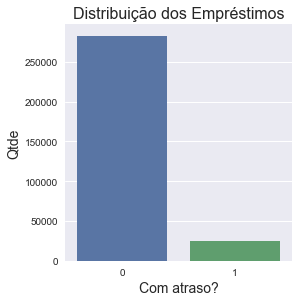

In [5]:
print("Distribuição da variável - Good(0) e Bad(1): ")
print(df_train["TARGET"].value_counts())

sns.factorplot(x ="TARGET", kind='count', data=df_train, size=4)
plt.title("Distribuição dos Empréstimos", fontsize=16)
plt.xlabel("Com atraso?", fontsize=14)
plt.ylabel("Qtde", fontsize=14)
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

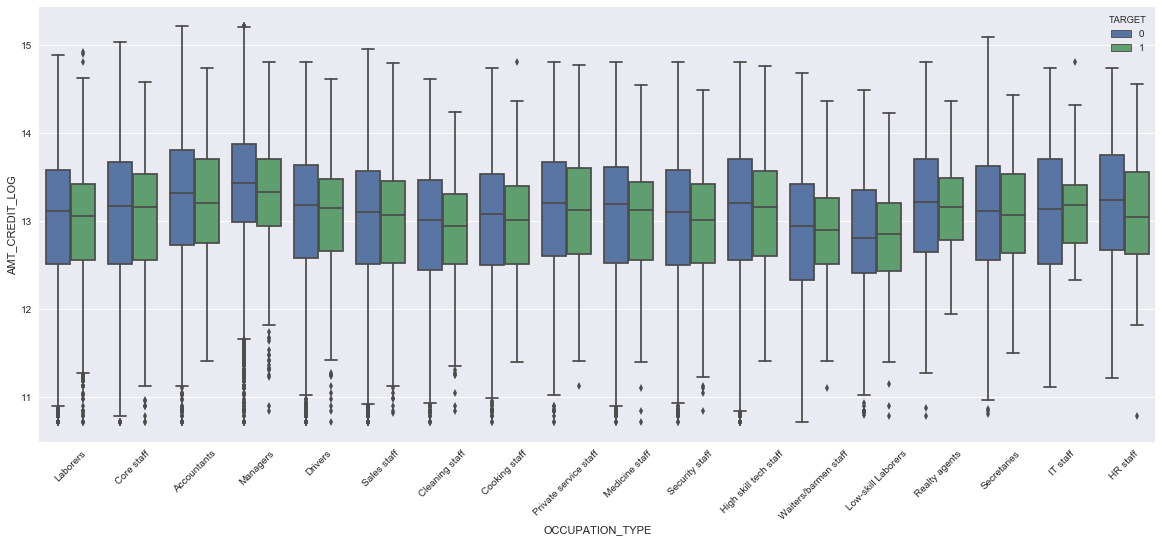

In [6]:
f, ax = plt.subplots(figsize=(20, 8))

df_train['AMT_CREDIT_LOG'] = np.log(df_train['AMT_CREDIT'])

sns.boxplot(data=df_train, x='OCCUPATION_TYPE', y='AMT_CREDIT_LOG', hue='TARGET')
plt.xticks(rotation=45)


In [ ]:
# Entender os dados. 
# Qual a distriuição da variavel target?
# Quais outros atributos parecem interessantes?


# sns.pairplot (df, hue = 'TARGET')

### Missing values

In [16]:
# utilizar o exemplo do print no cel

# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values_table(df_train_join).head()



Your selected dataframe has 187 columns.
There are 129 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_sum,227502,74.0
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
COMMONAREA_AVG,214865,69.9


In [ ]:
# Inputing missing values

from sklearn.preprocessing import Imputer

imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df_train_join)

train_imputer = imr.transform(df_train_join)
test_imputer = imr.transform(df_test_join)

## Pre-Processamento

In [ ]:
# Tratar dados numericos e categoricos (normalize)
# Verificar a correlação dos dados

In [69]:
from sklearn.preprocessing import Normalizer

def normalize_categoric(train, test): 

    categorical_feats = [f for f in train.columns if train[f].dtype == 'object']
    
    for col in categorical_feats:
        lb = preprocessing.LabelEncoder()
        lb.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
        train[col] = lb.transform(list(train[col].values.astype('str')))
        test[col] = lb.transform(list(test[col].values.astype('str')))
        
    return train, test
        

def normalize_numeric(train, test):
    
    train_target = train[['SK_ID_CURR', 'TARGET']]
    test_id = test['SK_ID_CURR']
    train.drop(['SK_ID_CURR', 'TARGET'], axis=1, inplace=True)
    test.drop('SK_ID_CURR', axis=1, inplace=True)
    
    numeric_feats = [f for f in train.columns if train[f].dtype == 'int64' or  train[f].dtype == 'float64']
    categorical_feats = [f for f in train.columns if train[f].dtype == 'object']
    
    train_cat = train[categorical_feats]
    test_cat = test[categorical_feats]
    train_num = train[numeric_feats]
    test_num = test[numeric_feats]
    
    scaler = Normalizer().fit(train_num.append(test_num).fillna(0))
    train_num = scaler.transform(train_num.fillna(0))
    test_num = scaler.transform(test_num.fillna(0))
    
    train_num = pd.DataFrame(train_num, columns=numeric_feats)
    test_num = pd.DataFrame(test_num, columns=numeric_feats)
    
    train_num['SK_ID_CURR'] = train_target['SK_ID_CURR']
    train_num['TARGET'] =  train_target['TARGET']
    test_num['SK_ID_CURR'] = test_id
    
    #train_num.concat(train_cat, axis=1)
    train_num = pd.concat([train_num, train_cat], axis=1)
    test_num = pd.concat([test_num, test_cat], axis=1)
    
    return train_num, test_num

In [71]:
train_norm, test_norm = normalize_numeric(df_train_join.copy(), df_test_join.copy())
train_norm, test_norm = normalize_categoric(train_norm, test_norm)

In [72]:
print(df_train_join.shape)
print(train_norm.shape)

print(df_test_join.shape)
print(test_norm.shape)

(307511, 187)
(307511, 187)
(48744, 186)
(48744, 186)


## Feature Selection

In [75]:
##### FEATURE SELECTION #######

# ESTE CODIGO RETIRA AS COLUNAS COM ALTA CORRELAÇÃO

# Set the threshold
threshold = 0.90

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])
    
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))
# print(cols_to_remove)

#train_corrs_removed = df_train.drop(cols_to_remove, axis=1)
#test_corrs_removed = df_test.drop(cols_to_remove, axis=1)

#print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
#print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Number of columns to remove:  69
['NONLIVINGAPARTMENTS_MODE', 'ELEVATORS_MEDI', 'NONLIVINGAREA_MODE', 'bureau_CREDIT_DAY_OVERDUE_count', 'bureau_CREDIT_DAY_OVERDUE_sum', 'bureau_AMT_CREDIT_SUM_max', 'FLOORSMAX_MODE', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT_W_CITY', 'APARTMENTS_MODE', 'COMMONAREA_MEDI', 'bureau_DAYS_CREDIT_sum', 'bureau_DAYS_CREDIT_ENDDATE_count', 'bureau_AMT_CREDIT_SUM_LIMIT_count', 'bureau_CNT_CREDIT_PROLONG_sum', 'LIVE_REGION_NOT_WORK_REGION', 'ELEVATORS_AVG', 'bureau_DAYS_CREDIT_ENDDATE_sum', 'bureau_AMT_CREDIT_SUM_DEBT_count', 'DAYS_EMPLOYED_PERCENT', 'YEARS_BUILD_MEDI', 'CNT_FAM_MEMBERS', 'ENTRANCES_MEDI', 'LANDAREA_MODE', 'FLOORSMAX_MEDI', 'APARTMENTS_MEDI', 'ELEVATORS_MODE', 'LIVINGAPARTMENTS_AVG', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'bureau_DAYS_ENDDATE_FACT_sum', 'bureau_DAYS_CREDIT_count', 'YEARS_BEGINEXPLUATATION_MEDI', 'bureau_DAYS_CREDIT_UPDATE_count', 'YEARS_BEGINEXPLUATATION_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_AVG', 'burea

## Criando os modelos de ML

### resample

In [76]:
from sklearn.utils import resample

def downsampled(train):

    # Separate majority and minority classes
    df_majority = train[train.TARGET==0]
    df_minority = train[train.TARGET==1]

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=50000,     # to match minority class 24825
                                     random_state=7) # reproducible results

    # Combine minority class with downsampled majority class
    return pd.concat([df_majority_downsampled, df_minority])
    

train_downsampled = downsampled(train_norm)

# Display new class counts
train_downsampled.TARGET.value_counts()

train_downsampled.shape

(74825, 187)

In [83]:
# Avaliação usando Cross Validation

# Import dos módulos
from pandas import read_csv
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Separando o array em componentes de input e output
X = train_norm.drop(['TARGET', 'SK_ID_CURR'], axis=1)
Y = train_norm['TARGET']

# Definindo os valores para os folds
num_folds = 5
seed = 7

# Separando os dados em folds
kfold = model_selection.KFold(num_folds, True, random_state = seed)

param_test1 = {'n_estimators': [1000]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               min_samples_split=5,
                                                               min_samples_leaf=50,
                                                               max_leaf_nodes=4, 
                                                               max_depth=5,
                                                               max_features=2,
                                                               random_state=10),
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=-1,
                        iid=False, 
                        cv=5, 
                       verbose=4)

# Criando o modelo
modelo = gsearch1 #LogisticRegression()
resultado = model_selection.cross_val_score(modelo, X, Y, cv = kfold, scoring='roc_auc')

# Usamos a média e o desvio padrão
print("AUC: %.3f (%.3f)" % (resultado.mean(), resultado.std()))



Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_estimators=1000, score=0.6944426059572153, total=  43.0s
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   47.8s remaining:    0.0s


[CV] ....... n_estimators=1000, score=0.691695704070959, total=  42.0s
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] ...... n_estimators=1000, score=0.6914507153232494, total=  41.1s
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min remaining:    0.0s


[CV] ...... n_estimators=1000, score=0.6883386191020435, total=  41.7s
[CV] n_estimators=1000 ...............................................
[CV] ...... n_estimators=1000, score=0.6920052602072306, total=  44.1s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_estimators=1000, score=0.6933748136120979, total=  51.1s
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   56.7s remaining:    0.0s


[CV] ...... n_estimators=1000, score=0.6917977044410962, total=  50.5s
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV] ...... n_estimators=1000, score=0.6924589466865033, total=  51.2s
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.8min remaining:    0.0s


[CV] ...... n_estimators=1000, score=0.6924378005536542, total=  41.4s
[CV] n_estimators=1000 ...............................................
[CV] ....... n_estimators=1000, score=0.697701814940627, total=  44.0s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_estimators=1000, score=0.6922124712007677, total=  44.4s
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   48.7s remaining:    0.0s


[CV] ...... n_estimators=1000, score=0.6909674815626403, total=  43.4s
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] ...... n_estimators=1000, score=0.6920084771840536, total=  44.4s
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s


[CV] ...... n_estimators=1000, score=0.6902633181799203, total=  44.6s
[CV] n_estimators=1000 ...............................................
[CV] ...... n_estimators=1000, score=0.6940439797278726, total=  43.4s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_estimators=1000, score=0.6905355237652971, total=  44.4s
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   49.3s remaining:    0.0s


[CV] ....... n_estimators=1000, score=0.693967919236357, total=  42.7s
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] ....... n_estimators=1000, score=0.690641563406849, total=  41.4s
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s


[CV] ....... n_estimators=1000, score=0.690266416833366, total=  44.1s
[CV] n_estimators=1000 ...............................................
[CV] ...... n_estimators=1000, score=0.6995525531442321, total=  44.0s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_estimators=1000, score=0.6922294336295831, total=  40.0s
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   44.8s remaining:    0.0s


[CV] ...... n_estimators=1000, score=0.6925263120300366, total=  41.4s
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[CV] ...... n_estimators=1000, score=0.6866273814409762, total=  42.9s
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min remaining:    0.0s


[CV] ...... n_estimators=1000, score=0.6928190126583539, total=  40.0s
[CV] n_estimators=1000 ...............................................
[CV] ....... n_estimators=1000, score=0.693782181637379, total=  43.8s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.0min finished


AUC: 0.692 (0.003)


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [91]:
### ESTOU AQUI!! 
## Todo: alterar codigo para ser a minha funcao de criar 
##       modelo usando cross_validation e minimizar a alta variancia dos
##       dados.
## ENTENDER TODA ESSA LOGICA - pois gerou um resultado muito melhor que o que estava conseguindo atingir antes
# De 0.69 fui para 0.76 no Kaggle. 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import gc

def model(features, test_features, encoding = 'le', n_folds = 5):
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    test_features = test_features.drop(['SK_ID_CURR'], axis=1)
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        print('Encoder não aplicado')
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = GradientBoostingClassifier(learning_rate=0.1, 
                                           min_samples_split=5,
                                           min_samples_leaf=50,
                                           max_leaf_nodes=4, 
                                           max_depth=5,
                                           max_features=2,
                                           random_state=10, 
                                          n_estimators=1000)
        
        # Train the model
        model.fit(train_features, train_labels)
        
        # Record the best iteration
        # best_iteration = model.best_iteration_
        
        # Record the feature importances
        # feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features)[:, 1]
        
        # Record the best score
        #valid_score = model.best_score_['valid']['auc']
        #train_score = model.best_score_['train']['auc']
        
        #valid_scores.append(valid_score)
        #train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

#app_train = pd.DataFrame(app_train)
#app_train['TARGET'] = train['TARGET']
#app_train.columns = train.columns
#app_test = pd.DataFrame(app_test, columns=test.columns)

submission, fi, metrics = model(train_norm, test_norm)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 185)
Testing Data Shape:  (48744, 185)


ValueError: arrays must all be same length

In [19]:
from sklearn import model_selection

def train_test_split(data):
    X = data.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    Y = data['TARGET']
    
    return model_selection.train_test_split(X, 
                                            Y, 
                                            test_size=0.3, 
                                            random_state=7)

X_train, X_test, y_train, y_test = train_test_split(train_downsampled)

X_train.shape

(52377, 128)

(52377, 128)
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:  3.7min remaining:   16.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.9min finished


Predict ...
Best params: {'n_estimators': 2500} - Best score: 0.7588399973103714
Accuracy: 0.7310228082679971


fbeta: 0.4521817442333392


              precision    recall  f1-score   support

           0       0.76      0.88      0.81     15062
           1       0.64      0.42      0.51      7386

   micro avg       0.73      0.73      0.73     22448
   macro avg       0.70      0.65      0.66     22448
weighted avg       0.72      0.73      0.71     22448


 Confusion Matrix:
[[13297  1765]
 [ 4273  3113]]


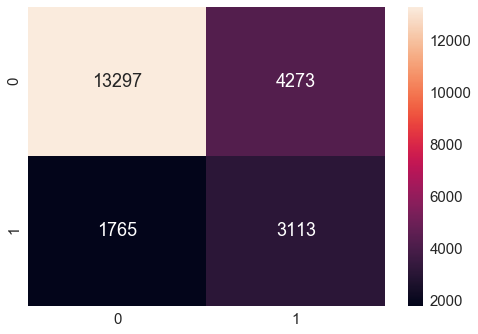

In [20]:
## MELHOR MODELO ATE ENTAO - 24/09

# COm as novas features deu overfitting. Pensar em como resolver 

## Confusion matrix 
# [[13320  1742]
# [ 4138  3248]]

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

print(X_train.shape)

# param_test1 = {'n_estimators':range(20,250,10)}
param_test1 = {'n_estimators': [250, 500, 700, 1000, 1300, 1500, 1800, 2000, 2500]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               min_samples_split=5,
                                                               min_samples_leaf=50,
                                                               max_leaf_nodes=4, 
                                                               max_depth=5,
                                                               max_features=2,
                                                               random_state=10),
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=-1,
                        iid=False, 
                        cv=5, 
                       verbose=4)

gsearch1.fit(X_train,y_train)


print('Predict ...')
y_pred = gsearch1.predict(X_test)

print('Best params: {0} - Best score: {1}'.format(gsearch1.best_params_, gsearch1.best_score_))

# Verificaar os resultados obtidos
print('Accuracy: {}'.format(accuracy_score(y_test,y_pred)))
print("\n")
print('fbeta: {}'.format(fbeta_score(y_test, y_pred, beta=2)))
print("\n")
print(classification_report(y_test, y_pred))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#Plot the confusion matrix
sns.set(font_scale=1.5)
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()



(52377, 86)
Predict ...
Best params: {'n_estimators': 250} - Best score: 0.7330646757164799
Accuracy: 0.7218014967925873


fbeta: 0.38674444212969855


              precision    recall  f1-score   support

           0       0.74      0.90      0.81     15062
           1       0.64      0.35      0.45      7386

   micro avg       0.72      0.72      0.72     22448
   macro avg       0.69      0.63      0.63     22448
weighted avg       0.71      0.72      0.70     22448


 Confusion Matrix:
[[13604  1458]
 [ 4787  2599]]


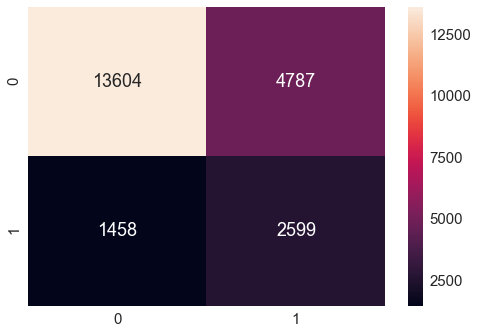

In [80]:
## MELHOR MODELO ATE ENTAO - 24/09

# COm as novas features deu overfitting. Pensar em como resolver 

## Confusion matrix 
# [[13320  1742]
# [ 4138  3248]]

from sklearn.ensemble import GradientBoostingClassifier

print(X_train.shape)

gbc_v1 = GradientBoostingClassifier(learning_rate=0.1, 
                                      min_samples_split=5,
                                      min_samples_leaf=50,
                                      max_leaf_nodes=4, 
                                      max_depth=5,
                                      max_features=2,
                                      random_state=10, 
                                      n_estimators=1000)

gbc_v1.fit(X_train,y_train)


print('Predict ...')
y_pred = gbc_v1.predict(X_test)

print('Best params: {0} - Best score: {1}'.format(gsearch1.best_params_, gsearch1.best_score_))

# Verificaar os resultados obtidos
print('Accuracy: {}'.format(accuracy_score(y_test,y_pred)))
print("\n")
print('fbeta: {}'.format(fbeta_score(y_test, y_pred, beta=2)))
print("\n")
print(classification_report(y_test, y_pred))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#Plot the confusion matrix
sns.set(font_scale=1.5)
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()



In [105]:
df_resultado = pd.DataFrame()



df_resultado['SK_ID_CURR'] = df_test['SK_ID_CURR']
test_predict = test_corrs_removed.drop('SK_ID_CURR', axis=1)

# test_predict.head()

df_resultado['TARGET'] = gsearch1.predict(test_predict)

df_resultado.to_csv('resultado_14_gridsearch1.csv', index=False)

In [92]:
print(X_train.shape)
print(X_test.shape)
print(train_corrs_removed.shape)
print(test_corrs_removed.shape)

(52377, 86)
(22448, 86)
(307511, 88)
(48744, 86)


In [91]:
test_corrs_removed['SK_ID_CURR'].head()

0    100001
1    100005
2    100013
3    100028
4    100038
Name: SK_ID_CURR, dtype: int64